<h1>Final Project Notebook</h1>
<p>
In this notebook we'll provide a breif overview of our data set and a brief code walk-through of our convolutional network model. We'll take a look at the different hyperparameters we considered. Afterwards, we'll conduct a run over several epochs and plot the training and accuracy curves using our updated batch size value. Finally, we conduct a final test on our separate test set to see the overall performance. 
</p>

In [ ]:
# import modules we'll be using
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import math

In [ ]:
# mount our drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


<h1>Data Exploration</h1>
<p>
We'll go ahead and load in our data as ready to go numpy arrays. The original data set consisted of over 220,000 images of ASL letters from Kaggle.com. An interesting thing about the data set is that it was a collage of other data sets present on Kaggle (among other sources). This allowed the images to have an inherent sense of variety to them. The data set initially started out as JPEG images that were downsized to 64x64x3 images. They were then converted into numpy arrays and were stardardized by dividing the values across by 255. After processing we stored the resulting arrays into numpy files and loaded them into our colab environments. For our neural networks we had to reshape our arrays back into their original image shapes for the neural networks to process. 
</p>

<a href="https://www.kaggle.com/debashishsau/aslamerican-sign-language-aplhabet-dataset">Here is a link to the original data set from Kaggle.com</a>

<a href="https://drive.google.com/file/d/1-yeHagUKW0tkbScegpdWND35INf8rkBu/view?usp=sharing">Here is a link to the to the notebook that was used to process the images into numpy arrays.</a>

In [ ]:
# load in the image data as numpy arrays
data = np.load('/content/drive/MyDrive/CIS520Project/Notebooks/data.npy').reshape(36400, 64, 64, 3)
labels = np.load('/content/drive/MyDrive/CIS520Project/Notebooks/labels.npy')

<p>
Let's visualize some of the images to see what we're working with here. As can be seen, the images are all colored and square in shape. They feature a variety of background imagery and have the hands at various positions. 
</p>

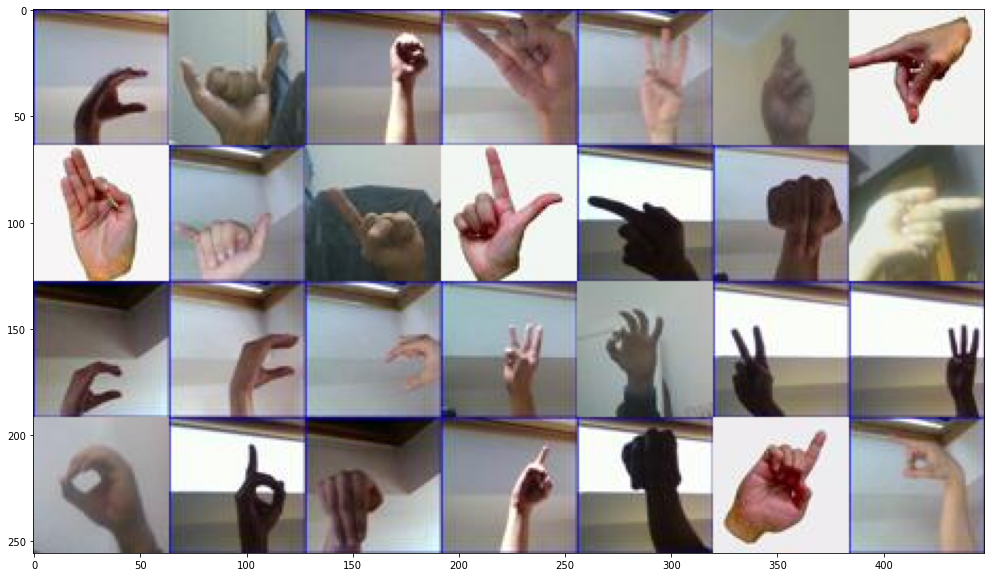

In [ ]:
# some code for displaying/visualizing our data set
plt.rcParams['figure.figsize'] = [20, 10]
display = np.hstack((data[0:4].reshape(256, 64, 3),
                     data[100:104].reshape(256, 64, 3),
                     data[200:204].reshape(256, 64, 3),
                     data[300:304].reshape(256, 64, 3),
                     data[400:404].reshape(256, 64, 3),
                     data[500:504].reshape(256, 64, 3),
                     data[600:604].reshape(256, 64, 3)))
plt.imshow(display)
plt.show()

<p>
Now we'll convert our numpy arrays into tensors and reshape them into Nx3x64x64 for the CNN to process properly. We'll also go ahead and split the data up as well. 1000 images for each class of letter for the training set, and 200 images for each class of letter for both the validation and testing sets each. 
</p>

In [ ]:
# convert our arrays to tenors for neural networks
data = Variable(torch.from_numpy(data).permute(0, 3, 1, 2).float())
labels = Variable(torch.from_numpy(labels).long())

In [ ]:
# split our data up (we'll just use 10% for the sake of computation time)
train_data = data[0:26000]
train_labels = labels[0:26000]
val_data = data[26000:31200]
val_labels = labels[26000:31200]
test_data = data[31200:36400]
test_labels = labels[31200:36400]

<h1>Final Project Model Walkthrough</h1>
<p>
Here is our CNN model. It was based on the model utilized in our Homework 4 CNN assignment due to the similarity in the problem set. In that assignment we were tasked with classifying images of several classes of clothes. In our case, we have 26 classes of hand gestures (ASL letters). We adopted the convolution-activation-maxpool format in order to construct the convolutional layers. Then we finished it off with a couple of linear layers that reduce the remaining features down to the number of classes for predicitions. 
</p>
<a href="https://colab.research.google.com/drive/1kmyiW5Qft_63LCdHrohCcKt5Xm-jgkR2?usp=sharing">Here is a link to our HW4 solution for reference of where we based our code/model from for our neural network.</a>
<p>
Here we begin the process of tuning some hyperparameters. We have three separate models here, differing by the number of convolutional layers (2, 3, 4) and are named as such. For convienince the models assume an activation function of ReLu and a batch size of 50 (we test these later). All the models throughout the notebook utilize the adam optimizer with a learning rate of 0.001 and a cross entropy loss function. These first three models do not have batch normalization (we test for that immediately after). First up is the CNN with 2 convolutional layers. We'll compare its performance with the 3 and 4 layered versions to see what number performs best given the data set. Note they are training on the training data set via in batches (as well as through epochs). All of these tests allowed for 5 epochs of training.
</p>

In [ ]:
# convolutional neural network class with 2 convolutional layers
class Net2(torch.nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    # activation function
    self.relu = torch.nn.ReLU()
    # convolution layers
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 32 x 32
    self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 16 x 16
    # linear layers
    self.linear1 = torch.nn.Linear(64*16*16, 64)
    self.linear2 = torch.nn.Linear(64, 26)

  def forward(self, x):
    # implement forward pass
    out = self.conv1(x)
    out = self.relu(out)
    out = self.maxpool1(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.maxpool2(out)
    out = self.linear1(out.reshape(out.size(0), -1))
    out = self.linear2(out)
    return out

In [ ]:
# intialize our model, loss function, and optimizer
net2 = Net2()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=1e-3)
# initalize variables for epoch training
num_epochs = 5
batch_size = 50
num_batches = math.ceil(len(train_data) / batch_size)
# train the model over epochs
for epoch in range(num_epochs):
  correct = 0
  total = 0 
  # randomize the training data
  idx = np.random.permutation(len(train_data))
  train_data_s, train_labels_s = train_data[idx], train_labels[idx]
  # initiate mini-batch gradient descent
  for i in range(num_batches):
    # grab our batch
    x, y = train_data_s[(i)*batch_size:(i+1)*batch_size], train_labels_s[(i)*batch_size:(i+1)*batch_size]
    # zero out
    optimizer.zero_grad()
    # get our predictions
    y_hat = net2(x)
    # calculate loss
    loss = criterion(y_hat, y)
    # update parameters and optimize
    loss.backward()
    optimizer.step()
    # accuracy
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  if epoch == (num_epochs - 1):
    accuracy_train = correct / total
  # status update
  print("Epoch {} Done".format(str(epoch)))
print('Training Accuracy:', accuracy_train)

# calculate validation accuracy
correct = 0
total = 0
batch_size = 50
num_batches = math.ceil(len(val_data) / batch_size)
# turn off gradients
with torch.no_grad():
  # run through the batches of the validation set
  for i in range(num_batches):
    x, y = val_data[(i)*batch_size:(i+1)*batch_size], val_labels[(i)*batch_size:(i+1)*batch_size]
    y_hat = net2(x)
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  accuracy_test = correct / total
  print('Validation Accuracy:', accuracy_test)

Epoch 0 Done
Epoch 1 Done
Epoch 2 Done
Epoch 3 Done
Epoch 4 Done
Training Accuracy: 0.8243076923076923
Validation Accuracy: 0.7953846153846154


<p>
Now to test the 3 layer network and see how it does compared to the other two. In our analysis this version of the model performed best.
</p>

In [ ]:
# convolutional neural network class with 3 convolutional layers
class Net3(torch.nn.Module):
  def __init__(self):
    super(Net3, self).__init__()
    # activation function
    self.relu = torch.nn.ReLU()
    # convolution layers
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 32 x 32
    self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 16 x 16
    self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
    self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 8 x 8
    # linear layers
    self.linear1 = torch.nn.Linear(64*8*8, 64)
    self.linear2 = torch.nn.Linear(64, 26)

  def forward(self, x):
    # implement forward pass
    out = self.conv1(x)
    out = self.relu(out)
    out = self.maxpool1(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.maxpool2(out)
    out = self.conv3(out)
    out = self.relu(out)
    out = self.maxpool3(out)
    out = self.linear1(out.reshape(out.size(0), -1))
    out = self.linear2(out)
    return out

In [ ]:
# intialize our model, loss function, and optimizer
net3 = Net3()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net3.parameters(), lr=1e-3)
# initalize variables for epoch training
num_epochs = 5
batch_size = 50
num_batches = math.ceil(len(train_data) / batch_size)
# train the model over epochs
for epoch in range(num_epochs):
  correct = 0
  total = 0 
  # randomize the training data
  idx = np.random.permutation(len(train_data))
  train_data_s, train_labels_s = train_data[idx], train_labels[idx]
  # initiate mini-batch gradient descent
  for i in range(num_batches):
    # grab our batch
    x, y = train_data_s[(i)*batch_size:(i+1)*batch_size], train_labels_s[(i)*batch_size:(i+1)*batch_size]
    # zero out
    optimizer.zero_grad()
    # get our predictions
    y_hat = net3(x)
    # calculate loss
    loss = criterion(y_hat, y)
    # update parameters and optimize
    loss.backward()
    optimizer.step()
    # acc
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  if epoch == (num_epochs - 1):
    accuracy_train = correct / total
  # status update
  print("Epoch {} Done".format(str(epoch)))
print('Training Accuracy:', accuracy_train)
# calculate validation accuracy
correct = 0
total = 0
batch_size = 50
num_batches = math.ceil(len(val_data) / batch_size)
# turn off gradients
with torch.no_grad():
  # run through the batches of the validation set
  for i in range(num_batches):
    x, y = val_data[(i)*batch_size:(i+1)*batch_size], val_labels[(i)*batch_size:(i+1)*batch_size]
    y_hat = net3(x)
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  accuracy_test = correct / total
  print('Validation Accuracy:', accuracy_test)

Epoch 0 Done
Epoch 1 Done
Epoch 2 Done
Epoch 3 Done
Epoch 4 Done
Training Accuracy: 0.9243846153846154
Validation Accuracy: 0.885


<p>
Now for the 4 layer version. This one performed better than the 2 layer version but not as well as the 3 layer version. 
</p>

In [ ]:
# convolutional neural network class with 4 convolutional layers
class Net4(torch.nn.Module):
  def __init__(self):
    super(Net4, self).__init__()
    # activation function
    self.tanh = torch.nn.Tanh()
    self.relu = torch.nn.ReLU()
    self.sigmoid = torch.nn.Sigmoid()
    # convolution layers
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 32 x 32
    self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 16 x 16
    self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
    self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 8 x 8
    self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
    self.maxpool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 4 x 4
    # linear layers
    self.linear1 = torch.nn.Linear(64*4*4, 64)
    self.linear2 = torch.nn.Linear(64, 26)

  def forward(self, x):
    # implement forward pass
    out = self.conv1(x)
    out = self.relu(out)
    out = self.maxpool1(out)
    out = self.conv2(out)
    out = self.relu(out)
    out = self.maxpool2(out)
    out = self.conv3(out)
    out = self.relu(out)
    out = self.maxpool3(out)
    out = self.conv4(out)
    out = self.relu(out)
    out = self.maxpool4(out)
    out = self.linear1(out.reshape(out.size(0), -1))
    out = self.linear2(out)
    return out

In [ ]:
# intialize our model, loss function, and optimizer
net4 = Net4()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net4.parameters(), lr=1e-3)
# initalize variables for epoch training
num_epochs = 5
batch_size = 50
num_batches = math.ceil(len(train_data) / batch_size)
# train the model over epochs
for epoch in range(num_epochs):
  correct = 0
  total = 0 
  # randomize the training data
  idx = np.random.permutation(len(train_data))
  train_data_s, train_labels_s = train_data[idx], train_labels[idx]
  # initiate mini-batch gradient descent
  for i in range(num_batches):
    # grab our batch
    x, y = train_data_s[(i)*batch_size:(i+1)*batch_size], train_labels_s[(i)*batch_size:(i+1)*batch_size]
    # zero out
    optimizer.zero_grad()
    # get our predictions
    y_hat = net4(x)
    # calculate loss
    loss = criterion(y_hat, y)
    # update parameters and optimize
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  if epoch == (num_epochs - 1):
    accuracy_train = correct / total
  # status update
  print("Epoch {} Done".format(str(epoch)))
print('Training Accuracy', accuracy_train)
# calculate validation accuracy
correct = 0
total = 0
batch_size = 50
num_batches = math.ceil(len(val_data) / batch_size)
# turn off gradients
with torch.no_grad():
  # run through the batches of the validation set
  for i in range(num_batches):
    x, y = val_data[(i)*batch_size:(i+1)*batch_size], val_labels[(i)*batch_size:(i+1)*batch_size]
    y_hat = net4(x)
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  accuracy_test = correct / total
  print('Validation Accuracy:', accuracy_test)

Epoch 0 Done
Epoch 1 Done
Epoch 2 Done
Epoch 3 Done
Epoch 4 Done
Training Accuracy 0.8916923076923077
Validation Accuracy: 0.8601923076923077


<p>
Now we'll assume the 3 layered model going forward (along with the batch size of 50 and the ReLu for now). Here we will test the batch normalization effect. It is observed that it'll outperform the previous version of the 3 layer network model.
</p> 

In [ ]:
# convolutional neural network class with 3 convolutional layers
# batch norm option
class Net3BN(torch.nn.Module):
  def __init__(self):
    super(Net3BN, self).__init__()
    # activation functions
    self.relu = torch.nn.ReLU()
    # convolution layers
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.batchnorm1 = torch.nn.BatchNorm2d(32)
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 32 x 32
    self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.batchnorm2 = torch.nn.BatchNorm2d(32)
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 16 x 16
    self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
    self.batchnorm3 = torch.nn.BatchNorm2d(64)
    self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 8 x 8
    # linear layers
    self.linear1 = torch.nn.Linear(64*8*8, 64)
    self.batchnorm4 = torch.nn.BatchNorm1d(64)
    self.linear2 = torch.nn.Linear(64, 26)
    self.batchnorm5 = torch.nn.BatchNorm1d(26)

  def forward(self, x):
    # implement forward pass
    out = self.batchnorm1(self.conv1(x))
    out = self.relu(out)
    out = self.maxpool1(out)
    out = self.batchnorm2(self.conv2(out))
    out = self.relu(out)
    out = self.maxpool2(out)
    out = self.batchnorm3(self.conv3(out))
    out = self.relu(out)
    out = self.maxpool3(out)
    out = self.batchnorm4(self.linear1(out.reshape(out.size(0), -1)))
    out = self.linear2(out)
    return out

In [ ]:
# intialize our model, loss function, and optimizer
net3BN = Net3BN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net3BN.parameters(), lr=1e-3)
# initalize variables for epoch training
num_epochs = 5
batch_size = 50
num_batches = math.ceil(len(train_data) / batch_size)
# train the model over epochs
for epoch in range(num_epochs):
  correct = 0
  total = 0 
  # randomize the training data
  idx = np.random.permutation(len(train_data))
  train_data_s, train_labels_s = train_data[idx], train_labels[idx]
  # initiate mini-batch gradient descent
  for i in range(num_batches):
    # grab our batch
    x, y = train_data_s[(i)*batch_size:(i+1)*batch_size], train_labels_s[(i)*batch_size:(i+1)*batch_size]
    # zero out
    optimizer.zero_grad()
    # get our predictions
    y_hat = net3BN(x)
    # calculate loss
    loss = criterion(y_hat, y)
    # update parameters and optimize
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  if epoch == (num_epochs - 1):
    accuracy_train = correct / total
  # status update
  print("Epoch {} Done".format(str(epoch)))
print('Training Accuracy', accuracy_train)
# calculate validation accuracy
correct = 0
total = 0
batch_size = 50
num_batches = math.ceil(len(val_data) / batch_size)
# turn off gradients
with torch.no_grad():
  # run through the batches of the validation set
  for i in range(num_batches):
    x, y = val_data[(i)*batch_size:(i+1)*batch_size], val_labels[(i)*batch_size:(i+1)*batch_size]
    y_hat = net3BN(x)
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  accuracy_test = correct / total
  print('Validation Accuracy', accuracy_test)

Epoch 0 Done
Epoch 1 Done
Epoch 2 Done
Epoch 3 Done
Epoch 4 Done
Training Accuracy 0.9667307692307693
Validation Accuracy 0.9336538461538462


<p>
We've arrived at what is essentially the final model. Here you can choose the activation function and batch size. In our analysis we found that the ReLu worked best for the CNN model and that a batch size of 100 was optimal compared to the other values we tried. For simplicity, we've defaulted to those values here so that we may see their performance. In our original testing phase we would simply re-run the following code with the functions/values we wanted to test for. Note that we are still testing with the validation set. 
</p>

In [ ]:
# convolutional neural network class with 3 convolutional layers
# options for activation functions
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # activation functions
    self.relu = torch.nn.ReLU()
    self.tanh = torch.nn.Tanh()
    self.sigmoid = torch.nn.Sigmoid()
    self.leaky_relu = torch.nn.LeakyReLU(0.1)
    # convolution layers
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.batchnorm1 = torch.nn.BatchNorm2d(32)
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 32 x 32
    self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.batchnorm2 = torch.nn.BatchNorm2d(32)
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 16 x 16
    self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
    self.batchnorm3 = torch.nn.BatchNorm2d(64)
    self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # out -> 8 x 8
    # linear layers
    self.linear1 = torch.nn.Linear(64*8*8, 64)
    self.batchnorm4 = torch.nn.BatchNorm1d(64)
    self.linear2 = torch.nn.Linear(64, 26)
    self.batchnorm5 = torch.nn.BatchNorm1d(26)

  def forward(self, x):
    # implement forward pass
    out = self.batchnorm1(self.conv1(x))
    out = self.relu(out)
    #out = self.leaky_relu(out)
    #out = self.tanh(out)
    #out = self.sigmoid(out)
    out = self.maxpool1(out)
    out = self.batchnorm2(self.conv2(out))
    out = self.relu(out)
    #out = self.leaky_relu(out)
    #out = self.tanh(out)
    #out = self.sigmoid(out)
    out = self.maxpool2(out)
    out = self.batchnorm3(self.conv3(out))
    out = self.relu(out)
    #out = self.leaky_relu(out)
    #out = self.tanh(out)
    #out = self.sigmoid(out)
    out = self.maxpool3(out)
    out = self.batchnorm4(self.linear1(out.reshape(out.size(0), -1)))
    out = self.linear2(out)
    return out

In [ ]:
# intialize our model, loss function, and optimizer
net = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
# initalize variables for epoch training
num_epochs = 5
batch_size = 100
# determine number of batches required
num_batches = math.ceil(len(train_data) / batch_size)
# train the model over epochs
for epoch in range(num_epochs):
  # for finding training accuracy
  correct = 0
  total = 0 
  # randomize the training data
  idx = np.random.permutation(len(train_data))
  train_data_s, train_labels_s = train_data[idx], train_labels[idx]
  # initiate mini-batch gradient descent
  for i in range(num_batches):
    # grab our batch
    x, y = train_data_s[(i)*batch_size:(i+1)*batch_size], train_labels_s[(i)*batch_size:(i+1)*batch_size]
    # zero out
    optimizer.zero_grad()
    # get our predictions
    y_hat = net(x)
    # calculate loss
    loss = criterion(y_hat, y)
    # update parameters and optimize
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  # save last epoch training accuracy recording
  if epoch == (num_epochs - 1):
    accuracy_train = correct / total
  # status update
  print("Epoch {} Done".format(str(epoch)))
print('Training Accuracy:', accuracy_train)
# calculate validation accuracy
correct = 0
total = 0
batch_size = 100
num_batches = math.ceil(len(val_data) / batch_size)
# turn off gradients
with torch.no_grad():
  # run through the batches of the validation set
  for i in range(num_batches):
    x, y = val_data[(i)*batch_size:(i+1)*batch_size], val_labels[(i)*batch_size:(i+1)*batch_size]
    y_hat = net(x)
    _, predicted = torch.max(y_hat.data, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()
  accuracy_test = correct / total
  print('Validation Accuracy:', accuracy_test)

Epoch 0 Done
Epoch 1 Done
Epoch 2 Done
Epoch 3 Done
Epoch 4 Done
Training Accuracy: 0.9746923076923077
Validation Accuracy: 0.9332692307692307


<p>
Here we will allow the model to train for several epochs and try and observe any trend in the respective training and testing accuracy plots that follow the run. Afterwards we will finally test the trained model on the test set.
</p>

In [ ]:
# intialize our model, loss function, and optimizer
net = Net() 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
# initalize variables for epoch training
num_epochs = 50
batch_size = 100
num_batches = math.ceil(len(train_data) / batch_size)
# keep tabs on training accuracy and loss
training_accuracy = []
testing_accuracy = []
training_loss = []
# train the model over epochs
for epoch in range(num_epochs):
  total = 0
  correct = 0
  epoch_loss = 0
  # randomize the training data
  idx = np.random.permutation(len(train_data))
  train_data_s, train_labels_s = train_data[idx], train_labels[idx]
  # initiate mini-batch gradient descent
  for i in range(num_batches):
    # grab our batch
    x, y = train_data_s[(i)*batch_size:(i+1)*batch_size], train_labels_s[(i)*batch_size:(i+1)*batch_size]
    # zero out
    optimizer.zero_grad()
    # get our predictions
    y_hat = net(x) # <----------------net
    # calculate loss
    loss = criterion(y_hat, y)
    # update parameters and optimize
    loss.backward()
    optimizer.step()
    # calculate training loss and append
    epoch_loss += loss.item()
    # get class label prediction
    _, predicted = torch.max(y_hat, 1)
    # calculate training accuracy and append
    total += y.size(0)
    correct += (predicted == y).sum().item()
  # save training loss/accuracy for the epoch
  accuracy = correct/total
  training_accuracy.append(accuracy)
  training_loss.append(epoch_loss)
  # status update
  print("Epoch {} Done".format(str(epoch)))

  # validation accuracy
  test_correct = 0
  test_total = 0
  batch_size = 100
  test_loss = 0
  num_batches = math.ceil(len(val_data) / batch_size)
  with torch.no_grad():
    for i in range(num_batches):
      x, y = val_data[(i)*batch_size:(i+1)*batch_size], val_labels[(i)*batch_size:(i+1)*batch_size]
      y_hat = net(x)
      _, predicted = torch.max(y_hat.data, 1)
      test_total += y.size(0)
      test_correct += (predicted == y).sum().item()
    test_accuracy = test_correct / test_total
    testing_accuracy.append(test_accuracy)
  print('Validation Accuracy:', test_accuracy)

Epoch 0 Done
Validation Accuracy: 0.7673076923076924
Epoch 1 Done
Validation Accuracy: 0.7932692307692307
Epoch 2 Done
Validation Accuracy: 0.8448076923076923
Epoch 3 Done
Validation Accuracy: 0.8561538461538462
Epoch 4 Done
Validation Accuracy: 0.8730769230769231
Epoch 5 Done
Validation Accuracy: 0.8871153846153846
Epoch 6 Done
Validation Accuracy: 0.8951923076923077
Epoch 7 Done
Validation Accuracy: 0.8938461538461538
Epoch 8 Done
Validation Accuracy: 0.9063461538461538
Epoch 9 Done
Validation Accuracy: 0.9171153846153847
Epoch 10 Done
Validation Accuracy: 0.9136538461538461
Epoch 11 Done
Validation Accuracy: 0.9155769230769231
Epoch 12 Done
Validation Accuracy: 0.9155769230769231
Epoch 13 Done
Validation Accuracy: 0.9182692307692307
Epoch 14 Done
Validation Accuracy: 0.9290384615384616
Epoch 15 Done
Validation Accuracy: 0.9307692307692308
Epoch 16 Done
Validation Accuracy: 0.9353846153846154
Epoch 17 Done
Validation Accuracy: 0.9326923076923077
Epoch 18 Done
Validation Accuracy: 0.9

<p>
Here we can see the plots of the accuracy of both the training and testing (validation) sets. Again, it is observed that the validation accuracy starts to plateu at around the 35-40 epoch mark. In our original analysis we had decided to run the model again for 40 epochs then conduct the test, but for the sake of computation time we'll go ahead and perform the test on this trained model.
</p>

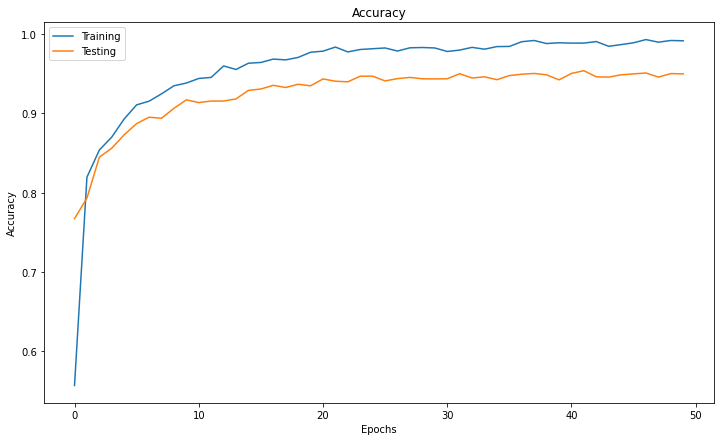

In [ ]:
list_epochs = [i for i in range(50)]
plt.rcParams['figure.figsize'] = [12, 7]
plt.plot(list_epochs, training_accuracy, label='Training')
plt.plot(list_epochs, testing_accuracy, label='Testing')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

<p>
Below is the plot of the training loss over the course of the epochs. The model learns rather quickly initially and then proceeds to learn more slowly as it goes on. The model seem to reach an asymptotic zone by the end of the training. 
</p>

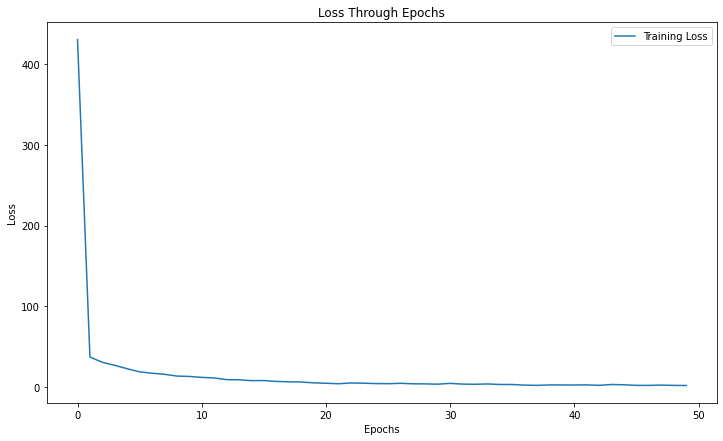

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.plot(list_epochs, training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Through Epochs')
plt.show()

<p>
Here we test the trained model on the separate test set to see how it does (representing our final perfomance for this particular model demonstration).
</p>

In [ ]:
# testing accuracy
test_correct = 0
test_total = 0
batch_size = 100
test_loss = 0
num_batches = math.ceil(len(val_data) / batch_size)
with torch.no_grad():
  for i in range(num_batches):
    x, y = test_data[(i)*batch_size:(i+1)*batch_size], test_labels[(i)*batch_size:(i+1)*batch_size]
    y_hat = net(x)
    _, predicted = torch.max(y_hat.data, 1)
    test_total += y.size(0)
    test_correct += (predicted == y).sum().item()
  testing_accuracy = test_correct / test_total
print('Test Accuracy:', testing_accuracy)

Test Accuracy: 0.9415384615384615
